In [153]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [194]:
df = pd.read_csv('roas.csv')
df.head()

,ad_id,source,ad_start,days_active,spend,impressions,clicks,ctr,n_leads,inbounded_perc,high_leads_perc,adult_leads_perc,z3_coverage,n_connected_calls,revenue,roas
0,120200176763890164,fb,"12 October, 2023",49,"22,513.79","1,382,232","6,264",0.453180,679,77.61,13.99,50.37,26.38,8,"42,300",1.88
1,120200449814490164,fb,"14 October, 2023",15,553.32,"23,049",64,0.277669,10,100.00,50.00,10.00,40.00,0,0,0
2,120200484217500164,fb,"15 October, 2023",20,"1,533.61","70,181",346,0.493011,22,86.36,31.82,22.73,21.05,0,0,0
3,120200484276340164,fb,"15 October, 2023",23,601.03,"25,237",158,0.626065,12,75.00,16.67,8.33,55.56,0,0,0
4,120200484292360164,fb,"15 October, 2023",19,194.96,"8,201",34,0.414584,2,100.00,0.00,0.00,50.00,0,0,0


In [195]:
df.spend = df.spend.str.replace(',','').astype(float)
df.clicks = df.clicks.str.replace(',','').astype(int)
df.impressions = df.impressions.str.replace(',','').astype(int)
df.n_connected_calls = df.n_connected_calls.str.replace(',','').astype(int)
df.revenue = df.revenue.str.replace(',','').astype(float)
df.n_leads = df.n_leads.str.replace(',','').astype(int)
df.roas = df.roas.str.replace(',','').astype(float)

In [196]:
df.inbounded_perc = df.inbounded_perc/100
df.high_leads_perc = df.high_leads_perc/100
df.adult_leads_perc = df.adult_leads_perc/100
df.z3_coverage = df.z3_coverage/100

In [197]:
df['impressions_per_day_per_spend/100'] = (df.impressions/df.spend/df.days_active)/100
df['connected_call_per_inbound'] = df.n_connected_calls/(df.n_leads*df.inbounded_perc)
df['lead_to_click_ratio'] = df.n_leads/df.clicks
df_cleaned = df.drop(columns = ['ad_id','source','ad_start','days_active','spend','impressions','clicks','n_leads','n_connected_calls'])
df_cleaned = df_cleaned.replace(np.inf,np.nan)
df_cleaned = df_cleaned.dropna()

In [198]:
roas = df_cleaned.pop('roas')
revenue = df_cleaned.pop('revenue')

In [199]:
roas.describe()

count    1178.000000
mean        6.695389
std        34.516896
min         0.000000
25%         0.000000
50%         0.686251
75%         4.820000
max      1015.380000
Name: roas, dtype: float64

In [200]:
df_cleaned.head(10)

,ctr,inbounded_perc,high_leads_perc,adult_leads_perc,z3_coverage,impressions_per_day_per_spend/100,connected_call_per_inbound,lead_to_click_ratio
0,0.453180,0.7761,0.1399,0.5037,0.2638,0.012530,0.015181,0.108397
1,0.277669,1.0000,0.5000,0.1000,0.4000,0.027771,0.000000,0.156250
2,0.493011,0.8636,0.3182,0.2273,0.2105,0.022881,0.000000,0.063584
3,0.626065,0.7500,0.1667,0.0833,0.5556,0.018256,0.000000,0.075949
4,0.414584,1.0000,0.0000,0.0000,0.5000,0.022139,0.000000,0.058824
5,0.832804,0.7262,0.2738,0.2262,0.2459,0.005627,0.000000,0.098476
6,0.510000,0.6809,0.1677,0.2067,0.2396,0.006161,0.001864,0.155639
7,0.427825,0.6798,0.1773,0.1576,0.3261,0.015239,0.000000,0.160601
8,0.446395,0.8178,0.3093,0.2415,0.4456,0.009118,0.000000,0.164460
9,0.437314,0.7171,0.2073,0.2043,0.2795,0.009393,0.000000,0.165313


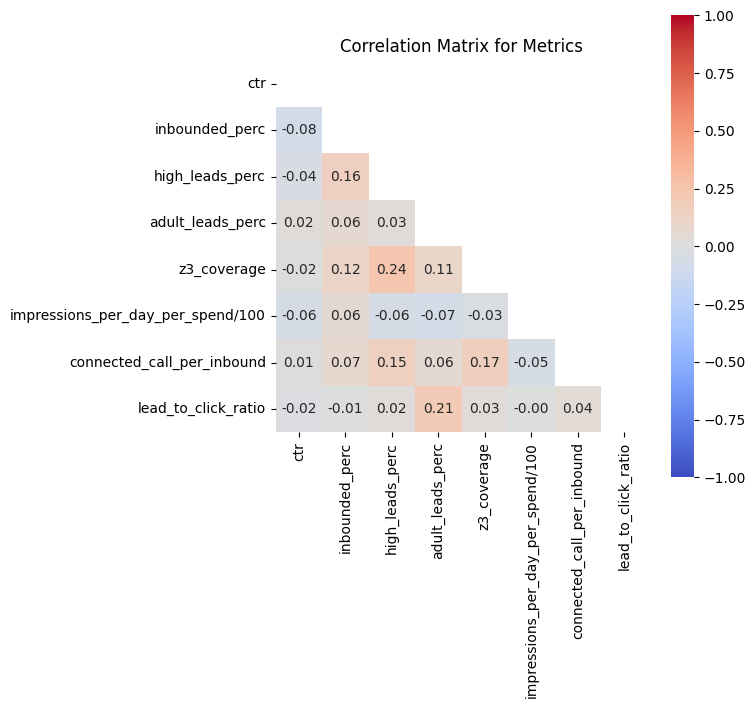

In [201]:
corrs = df_cleaned.corr()
mask = np.triu(np.ones_like(corrs, dtype = bool))
plt.figure(figsize=(6,6))
sns.heatmap(corrs.where(~mask), annot=True, cmap='coolwarm', vmin=-1, vmax=1, square=True, cbar=True, fmt=".2f")
plt.title("Correlation Matrix for Metrics")
plt.show()

In [202]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def compute_vif(df):
    vif = pd.DataFrame()
    vif['features'] = pd.Series(df.columns)
    vif['VIF_values'] = [variance_inflation_factor(df.values,i) for i in range(len(df.columns))]
    return vif.sort_values(by='VIF_values').reset_index(drop=True)

compute_vif(df_cleaned)

,features,VIF_values
0,connected_call_per_inbound,1.143315
1,lead_to_click_ratio,1.191190
2,ctr,1.253552
3,impressions_per_day_per_spend/100,1.424796
4,adult_leads_perc,1.908941
5,high_leads_perc,3.378545
6,z3_coverage,5.585985
7,inbounded_perc,7.327177


In [205]:
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_cleaned, roas/100, test_size=0.2, random_state=42)

# Initialize and fit the scaler
scaler = MinMaxScaler()

X_scaled_train = pd.DataFrame(scaler.fit_transform(X_train), columns=df_cleaned.columns.to_list()).reset_index(drop=True)
X_scaled_test = pd.DataFrame(scaler.transform(X_test), columns=df_cleaned.columns.to_list()).reset_index(drop=True)

# Add a constant (intercept) term for statsmodels
X_train_const = sm.add_constant(X_scaled_train)
X_test_const = sm.add_constant(X_scaled_test)

# Fit the OLS model with training data
model = sm.OLS(y_train.reset_index(drop=True), X_train_const).fit()

# Extract the coefficients and p-values, and sort by p-values
coefficients_df = pd.DataFrame({
    'Variable': model.params.index,
    'Coefficient': model.params.values,
    'P-Value': model.pvalues.values
})

# Sort by ascending p-values
coefficients_df_sorted = coefficients_df.sort_values(by='P-Value')

# Print the sorted summary
print(coefficients_df_sorted)


                            Variable  Coefficient       P-Value
7         connected_call_per_inbound     1.348014  2.252898e-60
4                   adult_leads_perc     0.070354  8.871103e-07
0                              const    -0.057461  9.348068e-03
2                     inbounded_perc     0.046977  8.002397e-02
3                    high_leads_perc     0.037913  1.427996e-01
6  impressions_per_day_per_spend/100     0.088755  2.477037e-01
5                        z3_coverage     0.025809  3.129182e-01
8                lead_to_click_ratio     0.076862  4.611644e-01
1                                ctr     0.024020  8.161331e-01


In [176]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

# Example with scaled data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cleaned)  # Standardize features

model = LinearRegression()
model.fit(X_scaled, roas/100)

cols = df_cleaned.columns
# Standardized coefficients
print("Standardized Coefficients:")
coefficients = model.coef_
for feature, coeff in sorted(zip(cols,coefficients),key = lambda x: x[1], reverse=True):
    print(f"{feature}: {coeff:.4f}")


Standardized Coefficients:
connected_call_per_inbound: 0.1848
adult_leads_perc: 0.0306
inbounded_perc: 0.0160
impressions_per_day_per_spend/100: 0.0157
lead_to_click_ratio: 0.0059
z3_coverage: 0.0039
ctr: -0.0004
high_leads_perc: -0.0150


In [138]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_cleaned, roas, test_size=0.2, random_state=42)
model = RandomForestRegressor()
model.fit(X_train, y_train)

# Assuming df_cleaned is your feature DataFrame and its columns correspond to feature names
feature_names = df_cleaned.columns

# Extract Gini importance
importances = model.feature_importances_

# Combine feature names and importances into a sorted list
feature_importance = sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True)

# Print feature importances
print("Feature Importances (Gini):")
for feature, importance in feature_importance:
    print(f"{feature}: {importance:.4f}")


Feature Importances (Gini):
connected_call_per_inbound: 0.4293
lead_to_click_ratio: 0.2317
adult_leads_perc: 0.0917
high_leads_perc: 0.0764
impressions_per_day_per_spend/100: 0.0653
ctr: 0.0417
z3_coverage: 0.0333
inbounded_perc: 0.0306


In [139]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the performance on the test set
mse = mean_squared_error(y_test, y_pred)  # Mean Squared Error
rmse = mse ** 0.5  # Root Mean Squared Error
r2 = r2_score(y_test, y_pred)  # R^2 score
mae = mean_absolute_error(y_test, y_pred)  # Mean Absolute Error

# Print metrics
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R^2 Score: {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")


Mean Squared Error (MSE): 3226.7415
Root Mean Squared Error (RMSE): 56.8044
R^2 Score: 0.3262
Mean Absolute Error (MAE): 8.5963
